# Yield curve construction

Yield curves are one of the corner stones of instrument pricing - they're used to discount cashflows among other things. The two curves of interest are the zero curve - which essentially tells you how much interest a lump sum invested today would bring in 1 week, 1 month, 1 year etc... and the forward curve - which tells you how much interest you would get by investing your lump sum, say, 6 months from today for a duration of a year (!).

The forward curve will be derived from the zero curve - which is our first step.

## Building the zero and forward curves with par swap yields

An interest rate swap is an agreement to swap a series of fixed cashflows for floating ones - in a way we're trading certainty for incertainty. A par swap is one that trades at the face value of the notional. The yield (or return) on those is directly observable in the market.

Let's suppose we have the following yields for swaps that mature at 6m intervals from today (that's a bit far fetched in practice but let's assume we can).

| Term | 0.5 | 1.0 | 1.5 | 2.0 | 2.5 | 3.0 | 3.5 |
|----|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Yield | 4.25%  | 5% | 5.55% | 6% | 6.5% | 7% | 7.5% |

Terms as expressed as fraction of a year. So the yield for a swap maturing in 18 months (1.5 years) is 5.55%. Note the yields are quoted yearly.

Plotting term against yield we get:


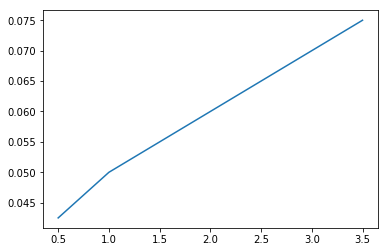

In [2]:
import pandas as pd
import numpy as np

swap_df = pd.DataFrame({'term': [0.5,1.0,1.5,2.0,2.5,3,3.5],
                        'yield': [0.0425,0.05,0.055,0.06,0.065,0.07,0.075]})

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(swap_df['term'], swap_df['yield'])

In order to build the zero curve we need to back out the discount factors. In a nutshell the discount factor is what we multiply a future cashflow by to have its value today (i.e. present value).

### Discount factors

The swaps in question pay semi-annually - so the swap maturing in 6 months only has one cashflow. We know it's price at par. Assuming notional is 100 it will pay $100 + 100\frac{4.25%}{2}= 102.125$ in 6 months' time. That means the present value of 102.125 is 100. The discount factor for 6 months, $df_{0.5}$, is therefore $\frac{100}{102.125} = 0.979192$.

Next we need to do this for one year. The coupon is $100\frac{5%}{2} = 2.5$. The cashflow is therefore $2.5 + 102.25$. Using a similar method as above, we have $100 = df_{0.5}2.5 + df_{1.0}102.5$. We already know what $df_{0.5}$ is so re-arranging we get $df_{1.0} = \frac{100-df_{0.5}2.5}{102.5} = 0.951727$.

We then repeat this procedure for every swap to yield subsequent discount factors. It might look a little cumbersome as such but there's a much easier way to back those out.

We start by creating a matrix of cashflows, with the columns representing the term. Not all swaps will have a cashflow for all terms. Indeed we get a triangular matrix:

In [3]:
# create a linear system for each swap based on its cashflow
cpn_freq = 2 # semi-annual
notional = 100
terms = swap_df['term'].values
cashflows = []
for _, row in swap_df.iterrows():
    coupon = row['yield']/2*notional
    stream = []
    for term in terms:
        stream.append(coupon + notional if row['term'] == term else coupon if term < row['term'] else 0)
    cashflows.append(stream)
cashflows

[[102.125, 0, 0, 0, 0, 0, 0],
 [2.5, 102.5, 0, 0, 0, 0, 0],
 [2.75, 2.75, 102.75, 0, 0, 0, 0],
 [3.0, 3.0, 3.0, 103.0, 0, 0, 0],
 [3.25, 3.25, 3.25, 3.25, 103.25, 0, 0],
 [3.5000000000000004,
  3.5000000000000004,
  3.5000000000000004,
  3.5000000000000004,
  3.5000000000000004,
  103.5,
  0],
 [3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 103.75]]

Giving us a system of linear equations:

$\begin{bmatrix}
100 \\
100 \\
\vdots \\
100
\end{bmatrix}
$
$
=
\begin{bmatrix}
102.125 & 0 & 0 & 0 & 0 & 0 & 0 \\
2.5 & 102.5 & 0 & 0 & 0 & 0 & 0 \\
\ddots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
3.75 & 3.75 & 3.75 & 3.75 & 3.75 & 3.75 & 103.75
\end{bmatrix}
\begin{bmatrix}
df_{0.5} \\
df_{1.0} \\
\vdots \\
df_{3.5}
\end{bmatrix}
$

Which one might solve via substitution (what we did above) or Gaussian elimination. For this we'll simply use `numpy`'s `linalg` module:

In [76]:
m = np.matrix(cashflows)
# swaps are at par so they're worth their face values
d = [100]*len(terms)
discount_factors = np.linalg.solve(m,d)
print(discount_factors)
swap_df['discount_factor'] = discount_factors
swap_df

[ 0.97919217  0.95172702  0.92155691  0.88779196  0.85079059  0.81093038
  0.76860281]


,term,yield,discount_factor,zero_coupon_rate,zero_rate,forward_rates,forward_rate
0,0.5,0.0425,0.979192,0.042055,0.042055,0.042055,0.042055
1,1.0,0.0500,0.951727,0.049477,0.049477,0.056899,0.056899
2,1.5,0.0550,0.921557,0.054460,0.054460,0.064427,0.064427
3,2.0,0.0600,0.887792,0.059509,0.059509,0.074654,0.074654
4,2.5,0.0650,0.850791,0.064636,0.064636,0.085143,0.085143
5,3.0,0.0700,0.810930,0.069858,0.069858,0.095968,0.095968
6,3.5,0.0750,0.768603,0.075195,0.075195,0.107216,0.107216


The first two discount factors match the ones we derived manually.

### Spot rates

Now that we have the discount factors, we can use those to determine the zero/spot rates (the continuously compounded interest rates). The relationship between discount factor and zero rate is $df_{t} = e^{-rt}$. Rearranging we get $ r = -\frac{ln(df)}{t}$. More details are available [here](https://en.wikipedia.org/wiki/Discounting#Discount_factor).

In [42]:
# converting df to continuously compounded rate
def zcp_rt(df,term): return -np.log(df)/term
print(zcp_rt(0.979192,0.5))

swap_df['zero_rate'] = swap_df.apply(lambda row: -np.log(row['discount_factor'])/row['term'], axis=1)
swap_df

0.0420550743842


,term,yield,discount_factor,zero_coupon_rate,zero_rate
0,0.5,0.0425,0.979192,0.042055,0.042055
1,1.0,0.0500,0.951727,0.049477,0.049477
2,1.5,0.0550,0.921557,0.054460,0.054460
3,2.0,0.0600,0.887792,0.059509,0.059509
4,2.5,0.0650,0.850791,0.064636,0.064636
5,3.0,0.0700,0.810930,0.069858,0.069858
6,3.5,0.0750,0.768603,0.075195,0.075195


Note though they are close, the zero rates do *not* match the par swap yields, and that's expected. We can now plot the two together:

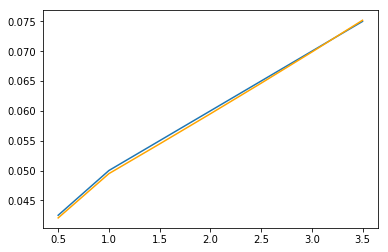

In [11]:
plt.plot(swap_df['term'], swap_df['yield'])
plt.plot(swap_df['term'], swap_df['zero_rate'], color='orange')

### Forward rates

Now that we have the the zero rates we can derive the forward rates for each tenor. Imagine we wanted to invest a lump sum for 6 months. After 6 months we would have earnt some interest. If we were to leave that for another 6 months it should be no different from having left it for a full year. In other words we have $(1+r_{0,1}) = (1+r_{0,0.5})^{\frac{1}{2}}(1+r_{0.5,1})^{\frac{1}{2}}$. The forward rate is $r_{0.5,1}$ and is therefore $(\frac{1+r_{0,1}}{(1+r_{0,0.5})^\frac{1}{2}})^2-1$.

Just like spot rates, we can extend this to derive $r_{1,1.5}$ etc... There is however a simpler way - we can use the discount factors as described [here](https://en.wikipedia.org/wiki/Forward_rate) (we're using continuous compounding).

This means $r_{0.5,1} = \frac{1}{1-0.5}(ln(df_{0,0.5})-ln(df_{0,1}))$. Extending this, we get:

[0.056899322936167368, 0.064427439853726357, 0.074654191816282467, 0.08514281343316063, 0.095967634256893863, 0.1072157631229993]
   term   yield  discount_factor  zero_coupon_rate  zero_rate  forward_rates  \
0   0.5  0.0425         0.979192          0.042055   0.042055       0.042055   
1   1.0  0.0500         0.951727          0.049477   0.049477       0.056899   
2   1.5  0.0550         0.921557          0.054460   0.054460       0.064427   
3   2.0  0.0600         0.887792          0.059509   0.059509       0.074654   
4   2.5  0.0650         0.850791          0.064636   0.064636       0.085143   
5   3.0  0.0700         0.810930          0.069858   0.069858       0.095968   
6   3.5  0.0750         0.768603          0.075195   0.075195       0.107216   

   forward_rate  
0      0.042055  
1      0.056899  
2      0.064427  
3      0.074654  
4      0.085143  
5      0.095968  
6      0.107216  


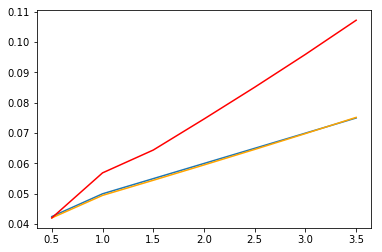

In [50]:
fwd_rates = []
for df_a, df_b in zip(swap_df['discount_factor'][:-1], swap_df['discount_factor'].shift(-1)):
    fwd_rates.append(2*(np.log(df_a) - np.log(df_b)))
print(fwd_rates)
swap_df['forward_rate'] = [swap_df['zero_rate'].values[0]] + fwd_rates
print(swap_df)
plt.plot(swap_df['term'], swap_df['yield'])
plt.plot(swap_df['term'], swap_df['zero_rate'], color='orange')
plt.plot(swap_df['term'], swap_df['forward_rate'], color='red')

### Validating the curve

Just like we can go from par swap yields to discount factors, we can go the other way too. Recall that for a par swap, the sum of the floating cashflows is equivalent to that of the fixed ones.

In other words we have $\frac{C_{yearly}}{freq}\sum_{i=1}^{n}df_{i} + df_{n}N = N$ which we can rewrite as $C_{yearly} = freq\frac{1-df_{n}}{\sum_{i=1}^{n}df_{i}}$.

Let's see if we can match our original values:

In [75]:
dfs = swap_df['discount_factor'].values
#print(type(dfs))
freq = 2
for i in range(len(dfs)):
    by = 2*(1-dfs[i])/sum(dfs[:i+1]) 
    print('idx: {idx}, backed out yield: {by:.4f}, original yield: {oy}'.format(idx=i, by=by, oy=swap_df.iloc[i]['yield']))


idx: 0, backed out yield: 0.0425, original yield: 0.0425
idx: 1, backed out yield: 0.0500, original yield: 0.05
idx: 2, backed out yield: 0.0550, original yield: 0.055
idx: 3, backed out yield: 0.0600, original yield: 0.06
idx: 4, backed out yield: 0.0650, original yield: 0.065
idx: 5, backed out yield: 0.0700, original yield: 0.07
idx: 6, backed out yield: 0.0750, original yield: 0.075


Success! Our curve is therefore consistent with its inputs.

### Conclusion

From par swap yields we managed to extract both spot and forward rates - both of which are essential to valuing a number of financial instruments (such as swaps!).

There are a number of caveats in practice, such as not having coupon dates lining up, but the overal logic should be roughly the same.